In [1]:
%matplotlib inline
from fastai import *
from fastai.tabular import *

C:\Users\gerar\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\gerar\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
path = Path('data/dont-call-me-turkey')
path

WindowsPath('data/dont-call-me-turkey')

In [3]:
path.absolute()

WindowsPath('C:/Users/gerar/fastai/course-v3/nbs/mine/data/dont-call-me-turkey')

In [4]:
path.ls()

[WindowsPath('data/dont-call-me-turkey/models'),
 WindowsPath('data/dont-call-me-turkey/sample_submission.csv'),
 WindowsPath('data/dont-call-me-turkey/test.json'),
 WindowsPath('data/dont-call-me-turkey/train.json')]

In [5]:
train = pd.read_json(path/'train.json')
test = pd.read_json(path/'test.json')
sample_submission = pd.read_csv(path/'sample_submission.csv')

In [6]:
print(test.columns)
print(train.columns)
print(sample_submission.head(4))

Index(['audio_embedding', 'end_time_seconds_youtube_clip',
       'start_time_seconds_youtube_clip', 'vid_id'],
      dtype='object')
Index(['audio_embedding', 'end_time_seconds_youtube_clip', 'is_turkey',
       'start_time_seconds_youtube_clip', 'vid_id'],
      dtype='object')
        vid_id  is_turkey
0  pyKh38FXD3E          0
1  THhP1idrWXA          0
2  jsw3T6GY2Nw          0
3  nFkXTMHcjMU          0


In [7]:
print (test.shape, train.shape)

(1196, 4) (1195, 5)


In [8]:
print(train[train['is_turkey']==1].index)

Int64Index([   1,    2,    3,    8,   12,   13,   18,   21,   23,   26,
            ...
            1163, 1165, 1168, 1169, 1172, 1173, 1174, 1184, 1185, 1192],
           dtype='int64', length=491)


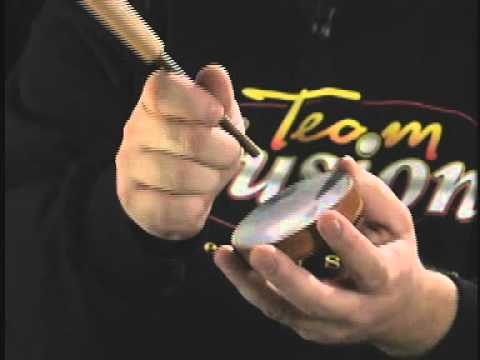

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo(train['vid_id'][1],start=train['start_time_seconds_youtube_clip'][1],end=train['end_time_seconds_youtube_clip'][1])

In [10]:
print(train['audio_embedding'].head())

#see the possible list lengths of the first dimension
print("train's audio_embedding can have this many frames: "+ str(train['audio_embedding'].apply(lambda x: len(x)).unique())) 
print("test's audio_embedding can have this many frames: "+ str(test['audio_embedding'].apply(lambda x: len(x)).unique())) 

#see the possible list lengths of the first element
print("each frame can have this many features: "+str(train['audio_embedding'].apply(lambda x: len(x[0])).unique()))

0    [[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...
1    [[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...
2    [[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...
3    [[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...
4    [[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...
Name: audio_embedding, dtype: object
train's audio_embedding can have this many frames: [10  9  2  3  8  5  6  7  4]
test's audio_embedding can have this many frames: [10  9  4  2  8  7  3  6  1]
each frame can have this many features: [128]


In [11]:
def pad_me(arr):
    result = np.zeros(128*10, dtype=float).reshape(10,128)
    result[:arr.shape[0],:arr.shape[1]] = arr*1.0000
    for row in range(arr.shape[0], result.shape[0]):
       ## print(arr[row % arr.shape[0]])
        result[row] = arr[row % arr.shape[0]]
    return result.flatten('F')

In [12]:
np.array(train['audio_embedding'][0][0], dtype=object)

array([172, 34, 216, 110, ..., 255, 129, 4, 255], dtype=object)

In [13]:
4 % 3, 5 % 3, 6 % 3

(1, 2, 0)

In [14]:
from sklearn.model_selection import train_test_split

#split the training data to have a validation set
xtrain = [pad_me(np.array(k)) for k in train['audio_embedding']]
ytrain = train['is_turkey'].values
training_df = pd.DataFrame(xtrain)
#cat_names = training_df.columns
training_df['target']=ytrain*1.0
xtest = [pad_me(np.array(k)) for k in test['audio_embedding']]
testing_df =pd.DataFrame(xtest)

In [15]:
dep_var = 'target'
procs = [FillMissing, Categorify, Normalize]

In [41]:
cat_names=[]
emb_siz = {}
for c in training_df.columns:
    cat_names.append(c)
    emb_siz[c] = 5

In [49]:
testing_df['target'] = np.zeros(1196)

In [72]:
test = TabularList.from_df(testing_df, path=path, cat_names=cat_names)
data = (TabularList.from_df(training_df, path=path, cat_names=cat_names, procs=procs)
                           .random_split_by_pct()
                           .label_from_df(cols=dep_var)
                           .add_test(test, label=0)
                           .databunch(num_workers=0))

In [56]:
loss_func = nn.CrossEntropyLoss()
def accuracy_mine(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    #print (input.float(), targs)
    return (input.float()==targs).float().mean()

def exp_rmspe_mins(pred:Tensor, targ:Tensor)->Rank0Tensor:

    "Exp RMSE between `pred` and `targ`."
    pred, targ = torch.exp(pred), torch.exp(targ)
    pct_var = (targ - pred)/targ
    return torch.sqrt((pct_var**2).mean())


acc_02 = partial(accuracy_thresh, thresh=0.2)

f_score = partial(fbeta, thresh=0.2)
learn = tabular_learner(data, layers=[1280,100],  emb_drop=0.05, emb_szs=emb_siz, metrics=[accuracy_mine, exp_rmspe_mins]  )

In [57]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(164, 5)
    (1): Embedding(162, 5)
    (2): Embedding(171, 5)
    (3): Embedding(164, 5)
    (4): Embedding(167, 5)
    (5): Embedding(161, 5)
    (6): Embedding(161, 5)
    (7): Embedding(168, 5)
    (8): Embedding(162, 5)
    (9): Embedding(163, 5)
    (10): Embedding(173, 5)
    (11): Embedding(179, 5)
    (12): Embedding(179, 5)
    (13): Embedding(184, 5)
    (14): Embedding(173, 5)
    (15): Embedding(175, 5)
    (16): Embedding(176, 5)
    (17): Embedding(170, 5)
    (18): Embedding(175, 5)
    (19): Embedding(178, 5)
    (20): Embedding(166, 5)
    (21): Embedding(159, 5)
    (22): Embedding(160, 5)
    (23): Embedding(156, 5)
    (24): Embedding(161, 5)
    (25): Embedding(158, 5)
    (26): Embedding(156, 5)
    (27): Embedding(162, 5)
    (28): Embedding(158, 5)
    (29): Embedding(151, 5)
    (30): Embedding(202, 5)
    (31): Embedding(200, 5)
    (32): Embedding(196, 5)
    (33): Embedding(196, 5)
    (34): Embedding(

In [58]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


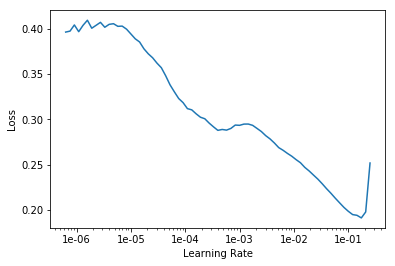

In [59]:
learn.recorder.plot()

In [60]:
learn.fit(10,1e-3)

Total time: 01:49
epoch  train_loss  valid_loss  accuracy_mine  exp_rmspe_mins
1      0.255665    0.403859    0.468619       0.432404        (00:10)
2      0.189389    0.357862    0.468619       0.429758        (00:10)
3      0.127820    0.246492    0.468619       0.439399        (00:10)
4      0.086648    0.154766    0.468619       0.484488        (00:11)
5      0.061124    0.074770    0.468619       0.597831        (00:10)
6      0.045547    0.048822    0.468619       0.675681        (00:11)
7      0.033717    0.037594    0.468619       0.728213        (00:10)
8      0.025219    0.037325    0.468619       0.726946        (00:10)
9      0.019088    0.037356    0.468619       0.724391        (00:10)
10     0.015402    0.036765    0.468619       0.734433        (00:11)



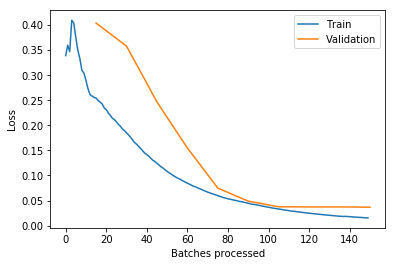

In [61]:
learn.recorder.plot_losses()

In [62]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


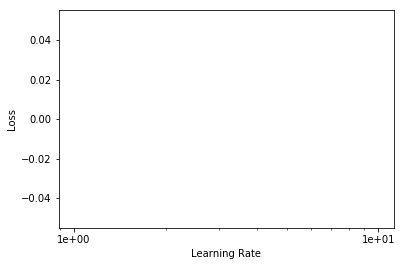

In [63]:
learn.recorder.plot()

In [64]:
learn.fit(5, 1e-7)

Total time: 00:55
epoch  train_loss  valid_loss  accuracy_mine  exp_rmspe_mins
1      0.004864    0.034358    0.468619       0.745613        (00:10)
2      0.004478    0.036799    0.468619       0.730494        (00:10)
3      0.004853    0.035624    0.468619       0.738451        (00:11)
4      0.005144    0.037891    0.468619       0.725291        (00:11)
5      0.005311    0.036700    0.468619       0.730298        (00:11)



In [39]:
row = testing_df.iloc[0:3]
row

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,177.0,168.0,170.0,171.0,175.0,168.0,173.0,164.0,166.0,165.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
1,169.0,162.0,163.0,161.0,163.0,161.0,166.0,165.0,177.0,166.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
2,165.0,163.0,158.0,160.0,151.0,153.0,167.0,167.0,163.0,159.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [95]:
preds, real = learn.get_preds(ds_type=DatasetType.Train)
print (preds, real)

tensor([[-1.6049e-02],
        [ 3.8029e-02],
        [-3.8842e-02],
        [ 9.7269e-01],
        [-1.7326e-02],
        [ 1.0189e+00],
        [-4.0317e-02],
        [ 1.7881e-02],
        [ 9.5019e-01],
        [ 1.3514e-02],
        [-1.0378e-03],
        [ 3.1770e-02],
        [ 9.6465e-01],
        [ 9.9786e-01],
        [ 9.4178e-01],
        [ 9.5419e-01],
        [ 9.7423e-01],
        [-4.5511e-03],
        [ 9.6430e-04],
        [ 9.7502e-01],
        [ 9.7822e-01],
        [-8.0720e-03],
        [-2.6173e-03],
        [ 2.6129e-02],
        [-3.8195e-02],
        [ 1.0129e+00],
        [ 9.9440e-01],
        [-1.4122e-02],
        [ 9.8284e-01],
        [-1.1022e-02],
        [ 9.1147e-03],
        [ 1.9882e-03],
        [ 4.1197e-03],
        [-2.3762e-02],
        [-1.8714e-02],
        [ 1.3299e-02],
        [ 1.0086e+00],
        [ 1.0134e+00],
        [ 9.5267e-03],
        [ 9.9045e-01],
        [ 1.0101e+00],
        [-5.1457e-02],
        [-3.0042e-02],
        [-1

        [-9.2725e-03]]) tensor([0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
        0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 1., 

In [87]:
learn.data.dl

<bound method DataBunch.dl of TabularDataBunch;
Train: LabelList
y: FloatList (956 items)
[FloatItem 0.0, FloatItem 1.0, FloatItem 1.0, FloatItem 1.0, FloatItem 0.0]...
Path: data\dont-call-me-turkey
x: TabularList (956 items)
[TabularLine 0 172.0; 1 171.0; 2 169.0; 3 180.0; 4 166.0; 5 160.0; 6 160.0; 7 164.0; 8 159.0; 9 165.0; 10 34.0; 11 39.0; 12 33.0; 13 39.0; 14 31.0; 15 20.0; 16 16.0; 17 27.0; 18 21.0; 19 33.0; 20 216.0; 21 199.0; 22 200.0; 23 218.0; 24 204.0; 25 186.0; 26 194.0; 27 201.0; 28 178.0; 29 188.0; 30 110.0; 31 121.0; 32 97.0; 33 118.0; 34 134.0; 35 121.0; 36 88.0; 37 96.0; 38 86.0; 39 93.0; 40 208.0; 41 238.0; 42 210.0; 43 213.0; 44 211.0; 45 211.0; 46 208.0; 47 215.0; 48 204.0; 49 234.0; 50 46.0; 51 62.0; 52 22.0; 53 73.0; 54 59.0; 55 43.0; 56 65.0; 57 51.0; 58 62.0; 59 92.0; 60 95.0; 61 59.0; 62 73.0; 63 80.0; 64 62.0; 65 44.0; 66 95.0; 67 89.0; 68 69.0; 69 107.0; 70 66.0; 71 61.0; 72 51.0; 73 43.0; 74 73.0; 75 91.0; 76 80.0; 77 71.0; 78 48.0; 79 66.0; 80 161.0; 81 1

In [132]:
row = training_df.iloc[0:3]

In [133]:
data1 = (TabularList.from_df(row, path=path, cat_names=cat_names, procs=procs)
                           .label_from_df(cols=dep_var))

In [145]:
from fastai.vision import *
cm = confusion_matrix( real, preds)
plot_confusion_matrix(cm, val_batches.class_indices)

NameError: name 'confusion_matrix' is not defined